In [60]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter

# Load your data
data = pd.read_stata('/Users/af955/Library/CloudStorage/OneDrive-YaleUniversity/ELSA_Databases/ecg_age.dta')

<ipython-input-60-4e48da936465>:7: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  data = pd.read_stata('/Users/af955/Library/CloudStorage/OneDrive-YaleUniversity/ELSA_Databases/ecg_age.dta')


In [61]:
# Time to event and event variables
time_to_event = 's_deraterohard_mes'
event = 's_deratero'

In [62]:
def calculate_eo_ratio(data, formula_vars):
    """
    Fits a Cox model and calculates the expected-to-observed ratio.

    Parameters:
        df (pd.DataFrame): The data frame containing the data
        formula_vars (list): The list of variables to include in the Cox model

    Returns:
        float: The expected-to-observed ratio
    """
   # Drop rows with NaN values in the relevant columns
    clean_df = data.dropna(subset=formula_vars + [time_to_event, event]).copy()
    
    # Fit the Cox proportional hazards model
    cph = CoxPHFitter()
    cph.fit(clean_df[formula_vars + [time_to_event, event]], duration_col=time_to_event, event_col=event)
    
    # Predict cumulative hazards for each individual
    cumulative_hazards = cph.predict_cumulative_hazard(clean_df[formula_vars])
    
    # Interpolate cumulative hazard values at each individual's follow-up time
    expected_events = clean_df.apply(lambda row: np.interp(row[time_to_event], cumulative_hazards.index, cumulative_hazards.loc[:, row.name]), axis=1).sum()
    
    # Get the observed number of events
    observed_events = clean_df[event].sum()
    
    # Calculate the expected-to-observed ratio
    eo_ratio = expected_events / observed_events if observed_events > 0 else np.nan
    
    return eo_ratio

In [63]:
model1_vars = ['idadea', 'sex']
eo_ratio_model1 = calculate_eo_ratio(data, model1_vars)
print("Expected-to-Observed Ratio for Model 1 (Age and Sex):", eo_ratio_model1)

Expected-to-Observed Ratio for Model 1 (Age and Sex): 0.9999999999999997


In [64]:
model2_vars = ['delta_ecg', 'idadea', 'sex']
eo_ratio_model2 = calculate_eo_ratio(data, model2_vars)
print("Expected-to-Observed Ratio for Model 2 (Delta ECG + Age + Sex):", eo_ratio_model2)

Expected-to-Observed Ratio for Model 2 (Delta ECG + Age + Sex): 1.0000000000000002


In [65]:
model3_vars = ['who_score']
eo_ratio_model3 = calculate_eo_ratio(data, model3_vars)
print("Expected-to-Observed Ratio for Model 3 (WHO Score Only):", eo_ratio_model3)

Expected-to-Observed Ratio for Model 3 (WHO Score Only): 1.0000000000000002


In [66]:
model4_vars = ['delta_ecg', 'who_score']
eo_ratio_model4 = calculate_eo_ratio(data, model4_vars)
print("Expected-to-Observed Ratio for Model 4 (WHO Score + Delta ECG):", eo_ratio_model4)

Expected-to-Observed Ratio for Model 4 (WHO Score + Delta ECG): 1.0


In [67]:
eo_ratios = {
    "Model 1 (Age + Sex)": eo_ratio_model1,
    "Model 2 (Delta ECG + Age + Sex)": eo_ratio_model2,
    "Model 3 (WHO Score Only)": eo_ratio_model3,
    "Model 4 (WHO Score + Delta ECG)": eo_ratio_model4
}

eo_ratios_df = pd.DataFrame.from_dict(eo_ratios, orient='index', columns=['Expected-to-Observed Ratio'])
print(eo_ratios_df)

                                 Expected-to-Observed Ratio
Model 1 (Age + Sex)                                     1.0
Model 2 (Delta ECG + Age + Sex)                         1.0
Model 3 (WHO Score Only)                                1.0
Model 4 (WHO Score + Delta ECG)                         1.0


In [69]:
# Function to fit the Cox model and get risk scores
def get_risk_scores(df, formula_vars):
    """
    Fit Cox model and calculate risk scores based on the specified variables.
    """
    # Drop rows with NaN values in relevant columns
    clean_df = df.dropna(subset=formula_vars + [time_to_event, event]).copy()
    
    # Fit Cox proportional hazards model
    cph = CoxPHFitter()
    cph.fit(clean_df[formula_vars + [time_to_event, event]], duration_col=time_to_event, event_col=event)
    
    # Predict risk scores
    risk_scores = cph.predict_partial_hazard(clean_df[formula_vars])
    return clean_df[event], risk_scores

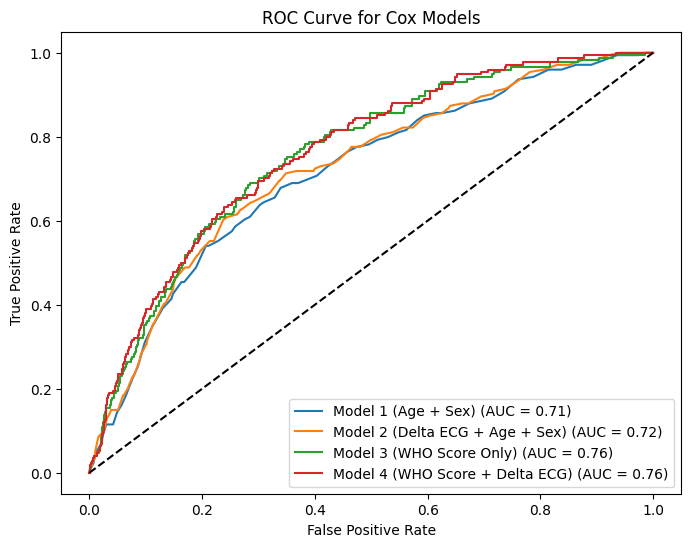

In [71]:
# Function to plot ROC curve
def plot_roc_curve(model_name, y_true, y_scores):
    """
    Calculate and plot the ROC curve for a given model.
    """
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc_score = roc_auc_score(y_true, y_scores)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})")

# Create a plot
plt.figure(figsize=(8, 6))

# Model 1: Age and Sex
y_true, risk_scores_model1 = get_risk_scores(data, ['idadea', 'sex'])
plot_roc_curve("Model 1 (Age + Sex)", y_true, risk_scores_model1)

# Model 2: Delta ECG + Age + Sex
y_true, risk_scores_model2 = get_risk_scores(data, ['delta_ecg', 'idadea', 'sex'])
plot_roc_curve("Model 2 (Delta ECG + Age + Sex)", y_true, risk_scores_model2)

# Model 3: WHO Score Only
y_true, risk_scores_model3 = get_risk_scores(data, ['who_score'])
plot_roc_curve("Model 3 (WHO Score Only)", y_true, risk_scores_model3)

# Model 4: WHO Score + Delta ECG
y_true, risk_scores_model4 = get_risk_scores(data, ['delta_ecg', 'who_score'])
plot_roc_curve("Model 4 (WHO Score + Delta ECG)", y_true, risk_scores_model4)

# Final plot adjustments
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for no-discrimination
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Cox Models')
plt.legend(loc="lower right")
plt.show()